# Introduction


The HR is concerned about the number of employees leaving. They assume
that employees who receive training at the time of probation will tend to be more loyal to the company when compared to those who do not receive training
training. You as an HR analyst are appointed to test this assumption.

# Install and Load Packages

In [3]:
!pip install causalml
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

import scikitplot as skplt

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
import causalml.metrics as metrics

plt.rcParams["figure.figsize"] = (18, 9)
plt.rcParams["font.size"] = 25
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Dataset

In [5]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/employee_turnover/turnover.csv",encoding = "ISO-8859-1")

# Data Inspection

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stag          1129 non-null   float64
 1   event         1129 non-null   int64  
 2   gender        1129 non-null   object 
 3   age           1129 non-null   float64
 4   industry      1129 non-null   object 
 5   profession    1129 non-null   object 
 6   traffic       1129 non-null   object 
 7   coach         1129 non-null   object 
 8   head_gender   1129 non-null   object 
 9   greywage      1129 non-null   object 
 10  way           1129 non-null   object 
 11  extraversion  1129 non-null   float64
 12  independ      1129 non-null   float64
 13  selfcontrol   1129 non-null   float64
 14  anxiety       1129 non-null   float64
 15  novator       1129 non-null   float64
dtypes: float64(7), int64(1), object(8)
memory usage: 141.2+ KB


In [7]:
raw_data.isna().sum()

stag            0
event           0
gender          0
age             0
industry        0
profession      0
traffic         0
coach           0
head_gender     0
greywage        0
way             0
extraversion    0
independ        0
selfcontrol     0
anxiety         0
novator         0
dtype: int64

As we can see on the summary above, fortunately the data didn't have any missing values.

Typecasting categorical variables into numeric

In [8]:
# Unique Value for Datatype Object Columns
empDfObj = pd.DataFrame(raw_data, columns=['industry', 'gender','profession','traffic','coach','head_gender','greywage','way'])
print("Contents of the Data: ")
print(empDfObj)

# Get a series object containing the count of unique elements
# in each column of dataframe
uniqueValues = empDfObj.nunique()
print('Count of unique value sin each column :')
print(uniqueValues)

# Unique Value for Datatype Object Columns
# Get unique elements in multiple columns
unique = pd.unique(raw_data[['industry', 'gender','profession','traffic','coach','head_gender','greywage','way']].values.ravel('k'))
print('Unique elements in object columns :')
print(unique)

Contents of the Data: 
             industry gender  profession      traffic    coach head_gender  \
0               Banks      m          HR  rabrecNErab       no           f   
1               Banks      m          HR        empjs       no           m   
2     PowerGeneration      f          HR  rabrecNErab       no           m   
3     PowerGeneration      f          HR  rabrecNErab       no           m   
4              Retail      m  Commercial        youjs      yes           f   
...               ...    ...         ...          ...      ...         ...   
1124            Banks      f          HR  rabrecNErab  my head           m   
1125            Banks      f          HR  rabrecNErab  my head           m   
1126          Telecom      f  Accounting           KA       no           f   
1127          Consult      f          HR        empjs       no           m   
1128           Retail      f          HR        youjs       no           f   

     greywage  way  
0       white  bus 

In [9]:
raw_data

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,10.611910,0,f,41.0,Banks,HR,rabrecNErab,my head,m,white,bus,8.6,3.4,2.6,4.8,8.3
1125,10.611910,0,f,41.0,Banks,HR,rabrecNErab,my head,m,white,bus,8.6,3.4,2.6,4.8,8.3
1126,118.800821,0,f,34.0,Telecom,Accounting,KA,no,f,white,bus,4.6,5.5,7.2,6.3,3.7
1127,49.412731,0,f,51.0,Consult,HR,empjs,no,m,grey,bus,3.8,7.6,5.7,6.3,5.2


# Preprocessing

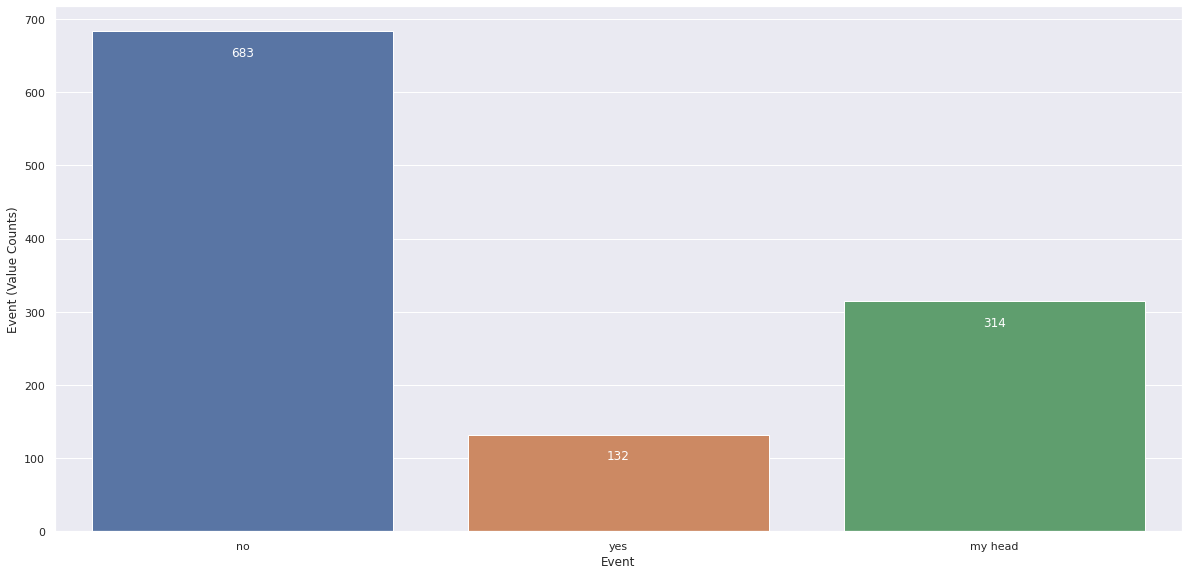

In [10]:
ax = sns.countplot(data = raw_data, x = 'coach');
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white')

plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Event", fontsize=12)
plt.ylabel("Event (Value Counts)", fontsize=12);

In [11]:
raw_data["coach"].value_counts()

no         683
my head    314
yes        132
Name: coach, dtype: int64

First, since we want to know impact of presence of the coach. We need eliminate one of these value. As we know, sometimes the company assign head of the worker as a coach. Then we can change "my head" to "yes"

In [12]:
raw_data.loc[raw_data["coach"] == "my head", "coach"] = "yes"

In [13]:
raw_data["coach"].value_counts()

no     683
yes    446
Name: coach, dtype: int64

In [14]:
# Balancing
raw_data = raw_data.sort_values(by='coach')
raw_data = raw_data.drop(raw_data.index[:237])
raw_data.reset_index(drop=True)

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,14.488706,0,m,30.0,Retail,Commercial,recNErab,no,m,grey,car,3.8,4.1,8.7,4.8,5.2
1,12.780287,1,f,35.0,Consult,Consult,friends,no,f,white,bus,5.4,5.5,3.3,4.8,6.7
2,53.420945,0,m,37.0,Mining,Law,friends,no,m,white,car,3.0,4.8,4.1,7.1,7.5
3,24.279261,0,m,27.0,transport,HR,friends,no,f,white,bus,3.0,7.6,8.7,3.3,2.9
4,44.550308,0,f,30.0,manufacture,HR,rabrecNErab,no,f,white,car,7.0,5.5,4.1,5.6,6.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,70.340862,0,f,31.0,manufacture,HR,friends,yes,f,white,bus,1.4,7.6,8.0,5.6,1.0
888,33.905544,0,f,23.0,Retail,HR,empjs,yes,f,white,bus,6.2,4.1,8.0,4.0,4.4
889,14.225873,0,f,31.0,IT,HR,friends,yes,f,white,bus,6.2,6.2,5.7,3.3,6.7
890,49.149897,1,f,28.0,Retail,HR,rabrecNErab,yes,m,white,bus,7.8,6.9,4.1,3.3,7.5


In [15]:
raw_data["coach"].value_counts()

no     446
yes    446
Name: coach, dtype: int64

# Train-Test Split Data

Next we could remove industry, profession, and traffic. This because these three columns have high cardinality. Then, split data before data exploration and engineering

In [16]:
X_train, X_test = train_test_split(
    raw_data.drop(["industry","profession","traffic"], axis = 1),
    test_size=0.5,
    random_state=1000
)

In [17]:
# treatment label
treatment_label = np.array(raw_data.coach == "yes").astype(int)
# conversion label
event_label = np.array(raw_data.event == 1).astype(int)
# Exclude treatment and conversion label
data_for_model = raw_data.drop(['coach', 'event'], axis = 1)

# Data Exploration

In [18]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446 entries, 266 to 107
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stag          446 non-null    float64
 1   event         446 non-null    int64  
 2   gender        446 non-null    object 
 3   age           446 non-null    float64
 4   coach         446 non-null    object 
 5   head_gender   446 non-null    object 
 6   greywage      446 non-null    object 
 7   way           446 non-null    object 
 8   extraversion  446 non-null    float64
 9   independ      446 non-null    float64
 10  selfcontrol   446 non-null    float64
 11  anxiety       446 non-null    float64
 12  novator       446 non-null    float64
dtypes: float64(7), int64(1), object(5)
memory usage: 48.8+ KB


In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446 entries, 51 to 422
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stag          446 non-null    float64
 1   event         446 non-null    int64  
 2   gender        446 non-null    object 
 3   age           446 non-null    float64
 4   coach         446 non-null    object 
 5   head_gender   446 non-null    object 
 6   greywage      446 non-null    object 
 7   way           446 non-null    object 
 8   extraversion  446 non-null    float64
 9   independ      446 non-null    float64
 10  selfcontrol   446 non-null    float64
 11  anxiety       446 non-null    float64
 12  novator       446 non-null    float64
dtypes: float64(7), int64(1), object(5)
memory usage: 48.8+ KB


Event 
Retain (0) 
Churn (1) 


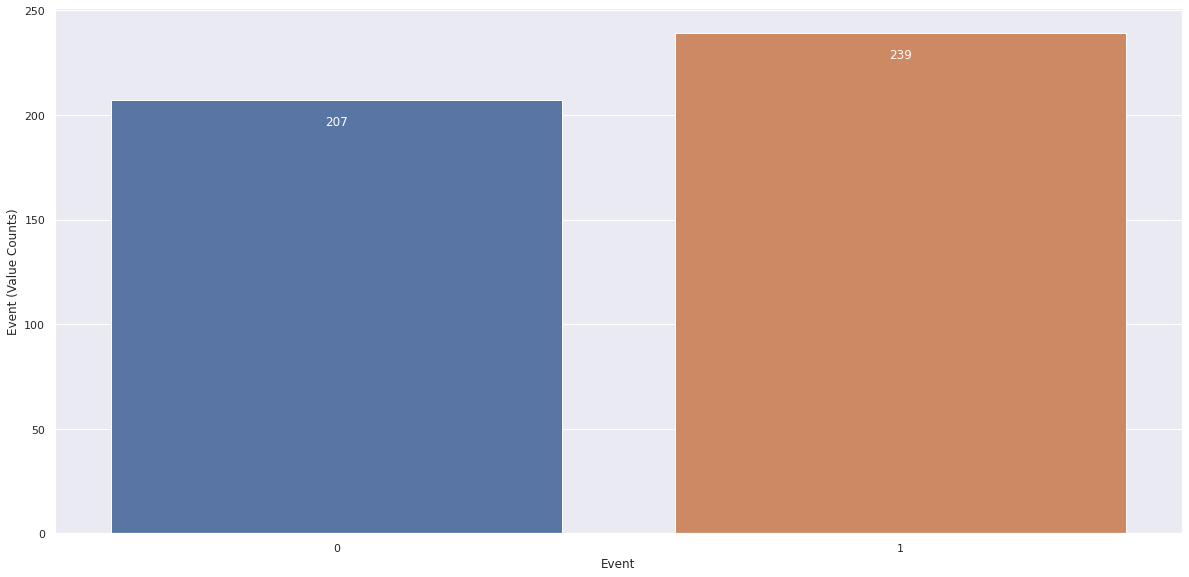

In [20]:
ax = sns.countplot(x="event", data=X_train)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white')

plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Event", fontsize=12)
plt.ylabel("Event (Value Counts)", fontsize=12);

print("Event ")
print("Retain (0) ")
print("Churn (1) ");

We can observe there imbalance case in our dataset. We can solve this in two ways:

- Post-modeling, by changing classification threhold to optimize metrics such as F1-Score, precision, recall, etc
- Pre-modeling, by doing resamping such as oversampling, downsampling, and mixed sampling

We gonna do pre-modelling oversampling if necessary

Next we gonna check numerical data distribution and multicolinearity for each variables


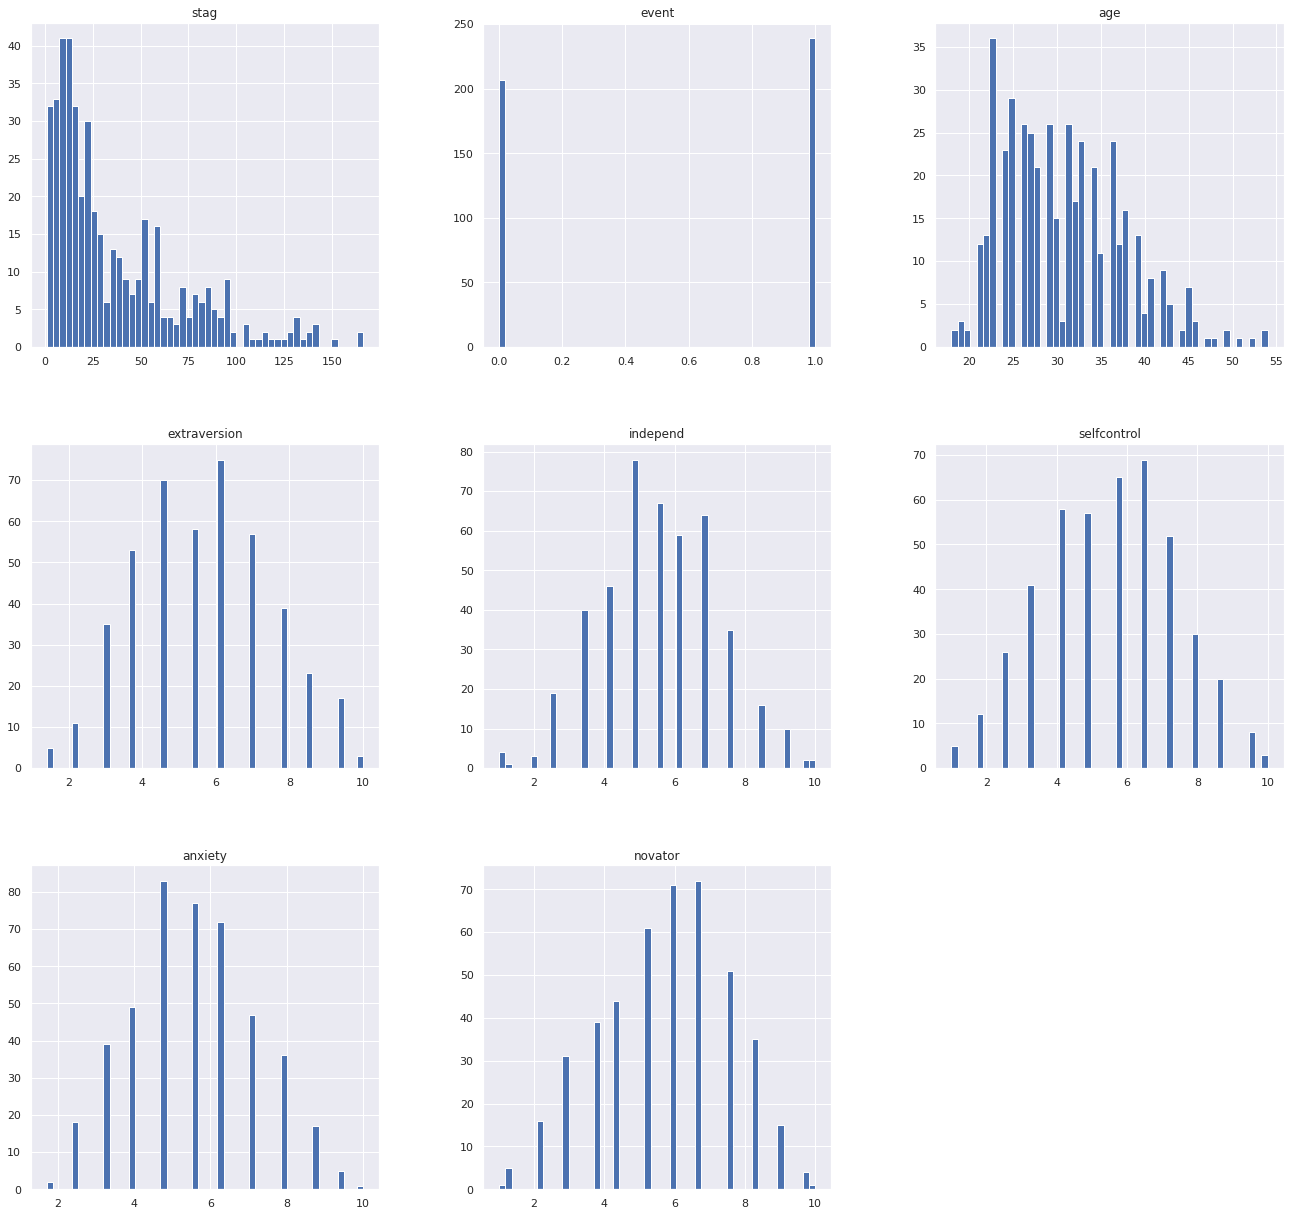

In [21]:
# check numerical data distribution
X_train.hist(bins=50, figsize = (20, 20));

From the data there is a variable with a numeric type: stag, age, extraversion, independ, selfcontrol, anxiety and novator
Meanwhile, categorical data include: industry, gender, profession, traffic,coach, head_gender, greywage and way.

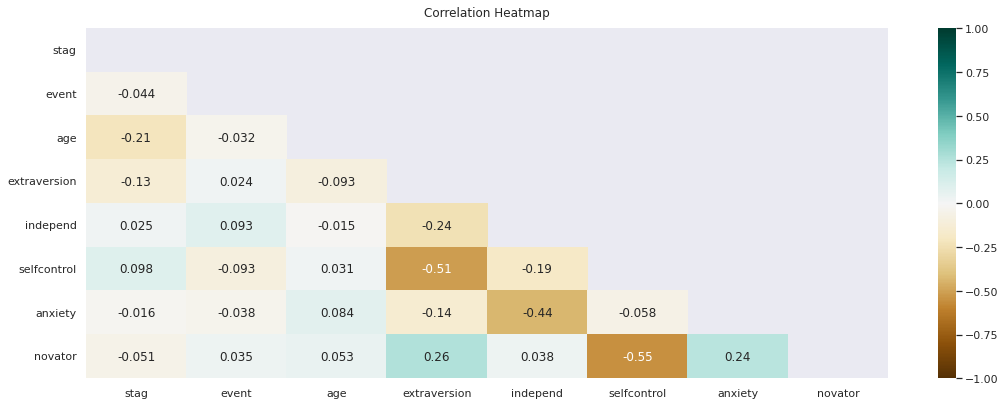

In [22]:
# Increase the size of the heatmap
plt.figure(figsize=(16, 6))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap
mask = np.triu(np.ones_like(X_train.corr(), dtype=np.bool))
heatmap = sns.heatmap(X_train.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

We observe multiple multicolinearity between predictor variables such as selfcontrol vs novator (-55%), selfcontrol vs extraversion (-51%), anxiety vs independ (44%) and many more.

## Categorical Data vs Event

**Gender vs Event**


Event: 
Retain (0) 
Churn (1) 


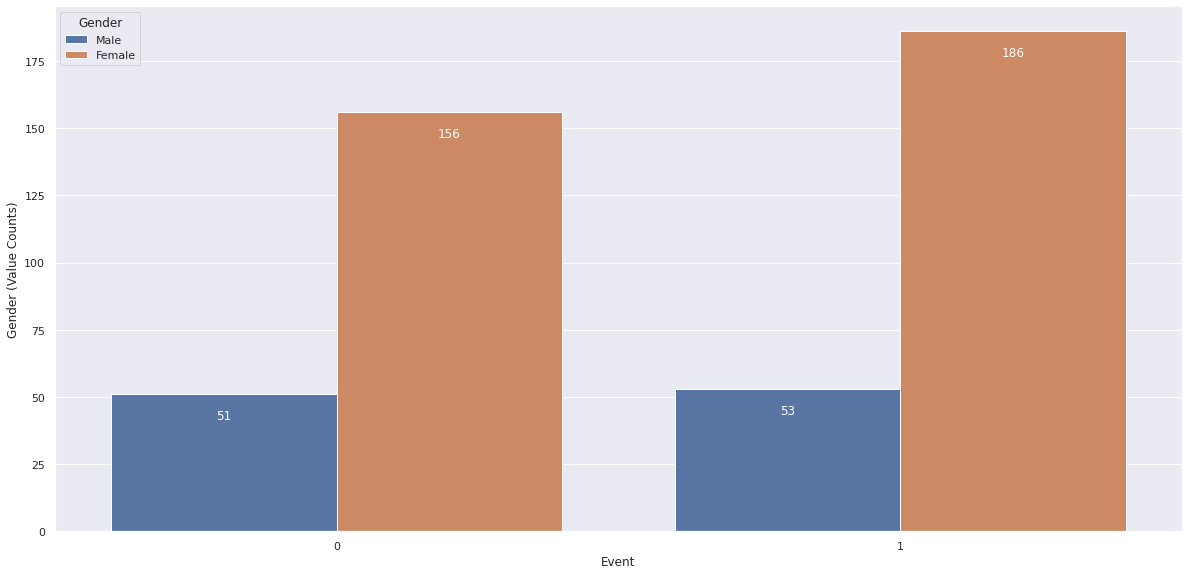

In [23]:
# Target feature is 'Attrition_Flag' in which 'Attrited Customer' means it's a churn (1) and 'Existing Customer' means there is no churn (0)
ax = sns.countplot(x='event', hue='gender', data=X_train);

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white')
plt.legend(title='Gender', loc='upper left', labels=['Male','Female'])
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Event", fontsize=12)
plt.ylabel("Gender (Value Counts)", fontsize=12)

print("Event: ")
print("Retain (0) ")
print("Churn (1) ");

Gender is dominated by female both from churn and retained. 

**Head Gender vs Event**


Event: 
Retain (0) 
Churn (1) 


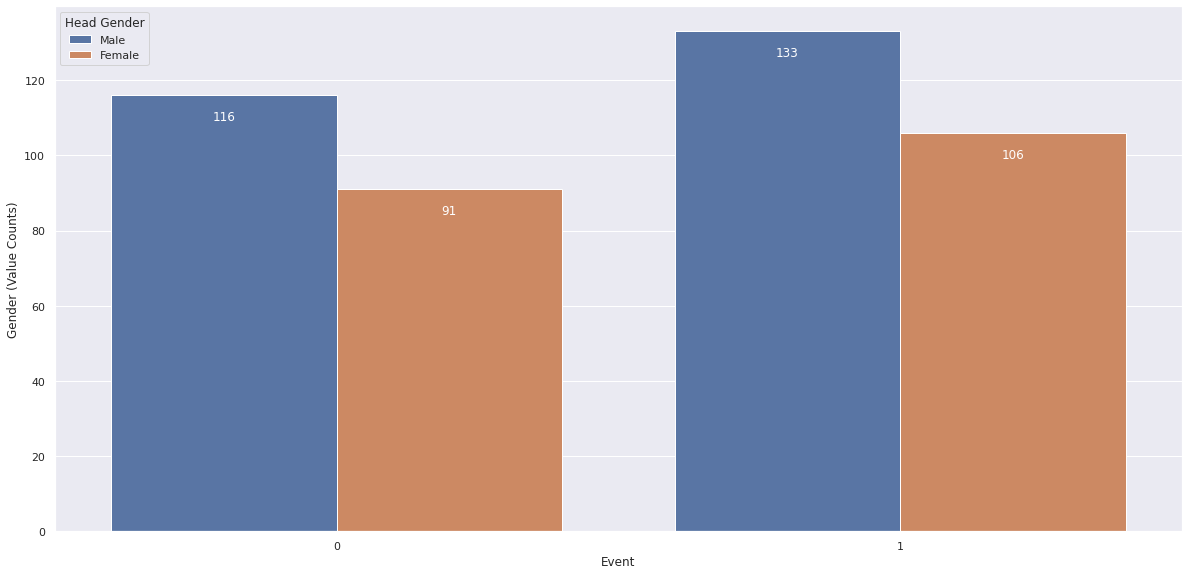

In [24]:
# Target feature is 'Attrition_Flag' in which 'Attrited Customer' means it's a churn (1) and 'Existing Customer' means there is no churn (0)
ax = sns.countplot(x='event', hue='head_gender', data=X_train);

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white')
plt.legend(title='Head Gender', loc='upper left', labels=['Male','Female'])
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Event", fontsize=12)
plt.ylabel("Gender (Value Counts)", fontsize=12)

print("Event: ")
print("Retain (0) ")
print("Churn (1) ");

Head gender is dominated by male both from churn and retained, however it is not significantly like gender variable.

**Coach vs Event**


Event: 
Retain (0) 
Churn (1) 


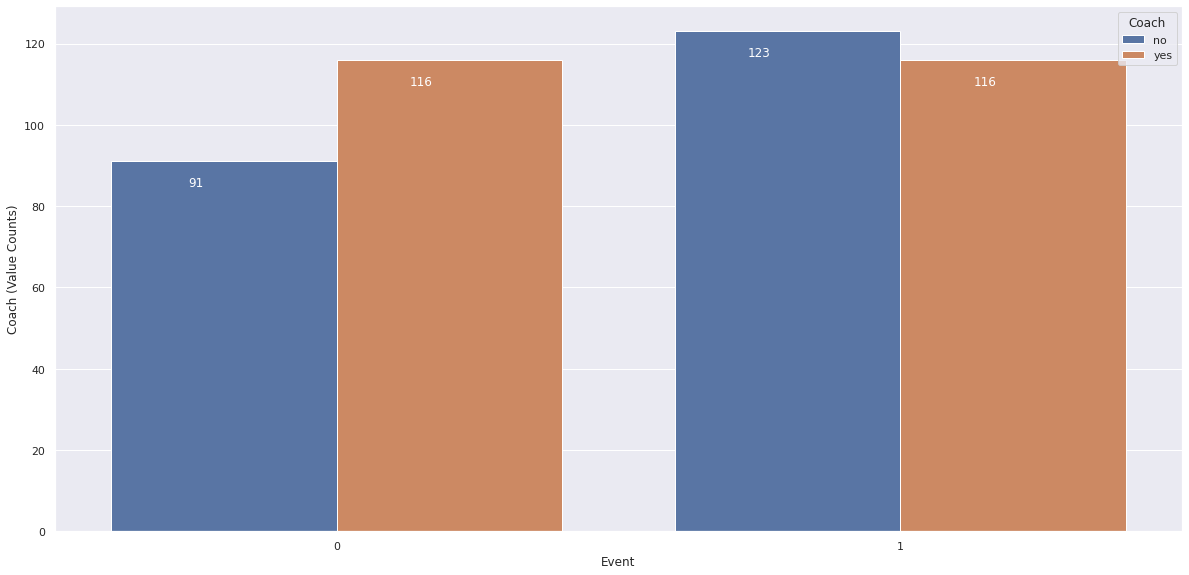

In [25]:
# Target feature is 'Attrition_Flag' in which 'Attrited Customer' means it's a churn (1) and 'Existing Customer' means there is no churn (0)
ax = sns.countplot(x='event', hue='coach', data=X_train);

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.15, p.get_height()), ha='center', va='top', color='white')


plt.legend(title='Coach', loc='upper right', labels=['no', 'yes', 'my head'])
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Event", fontsize=12)
plt.ylabel("Coach (Value Counts)", fontsize=12)

print("Event: ")
print("Retain (0) ")
print("Churn (1) ");

In term of coach, the employee with no coach (no treatment) more likely to churn.

**Event vs Greywage**

Event: 
Retain (0) 
Churn (1) 


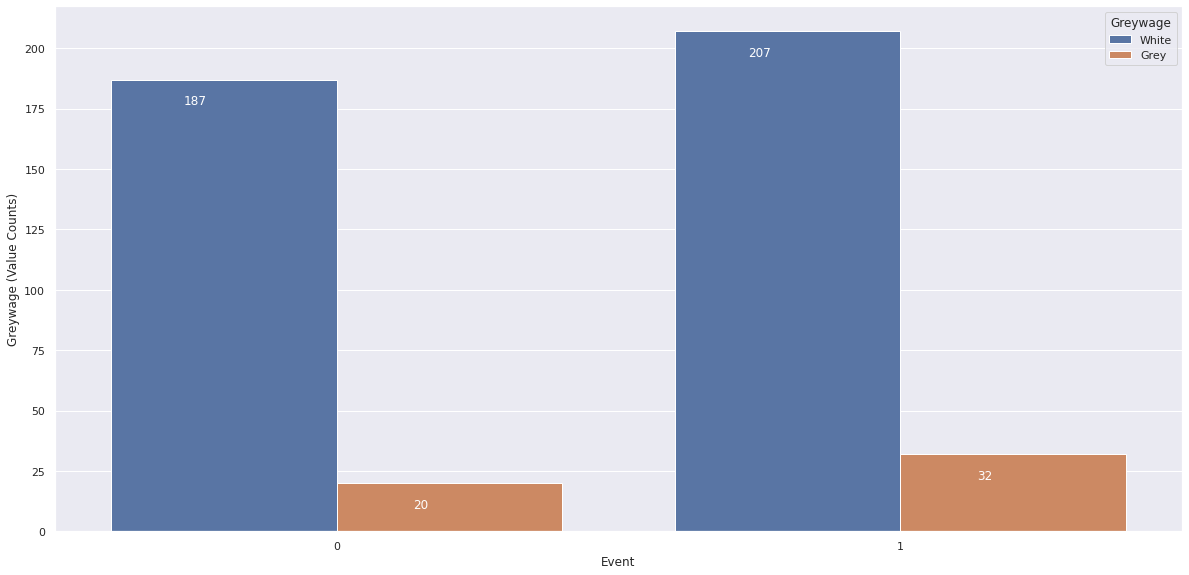

In [26]:
# Target feature is 'Attrition_Flag' in which 'Attrited Customer' means it's a churn (1) and 'Existing Customer' means there is no churn (0)
ax = sns.countplot(x='event', hue='greywage', data=X_train);

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.15, p.get_height()), ha='center', va='top', color='white')


plt.legend(title='Greywage', loc='upper right', labels=['White', 'Grey'])
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Event", fontsize=12)
plt.ylabel("Greywage (Value Counts)", fontsize=12)

print("Event: ")
print("Retain (0) ")
print("Churn (1) ");

The data shows that the distribution of users with white category is far more higher than greywage category.

**Way vs Event**

Event: 
Retain (0) 
Churn (1) 


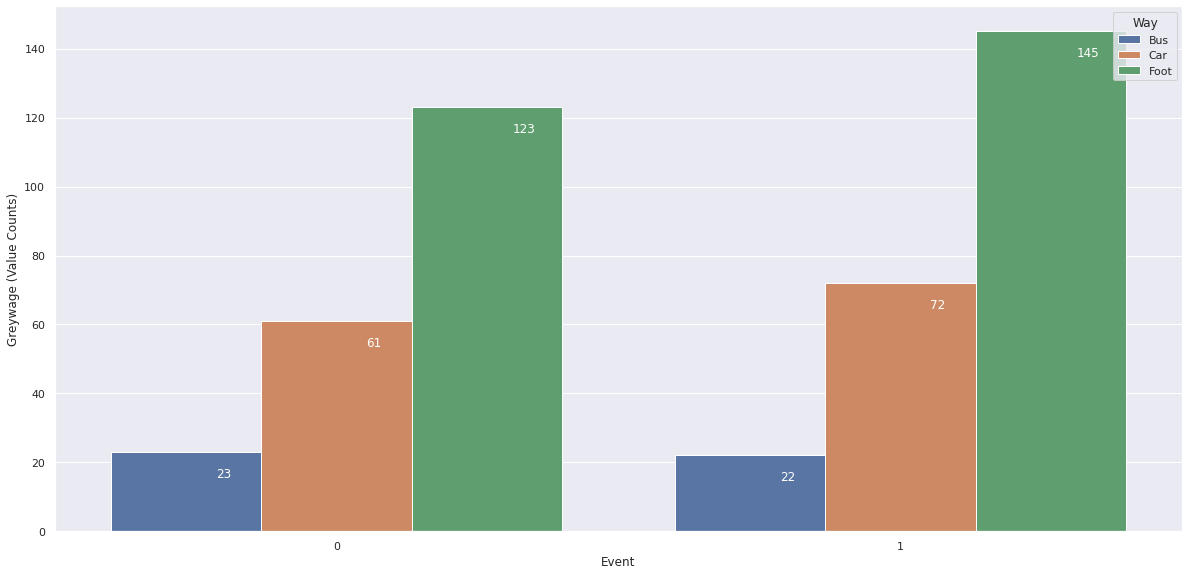

In [27]:
# Target feature is 'Attrition_Flag' in which 'Attrited Customer' means it's a churn (1) and 'Existing Customer' means there is no churn (0)
ax = sns.countplot(x='event', hue='way', data=X_train);

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white')


plt.legend(title='Way', loc='upper right', labels=['Bus', 'Car', 'Foot'])
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Event", fontsize=12)
plt.ylabel("Greywage (Value Counts)", fontsize=12)

print("Event: ")
print("Retain (0) ")
print("Churn (1) ");

The data shows that the distribution of employee that going for work on foot is high potential to churn and retain than car and bus.

## Numerical Data vs Churn

**Age vs Churn**

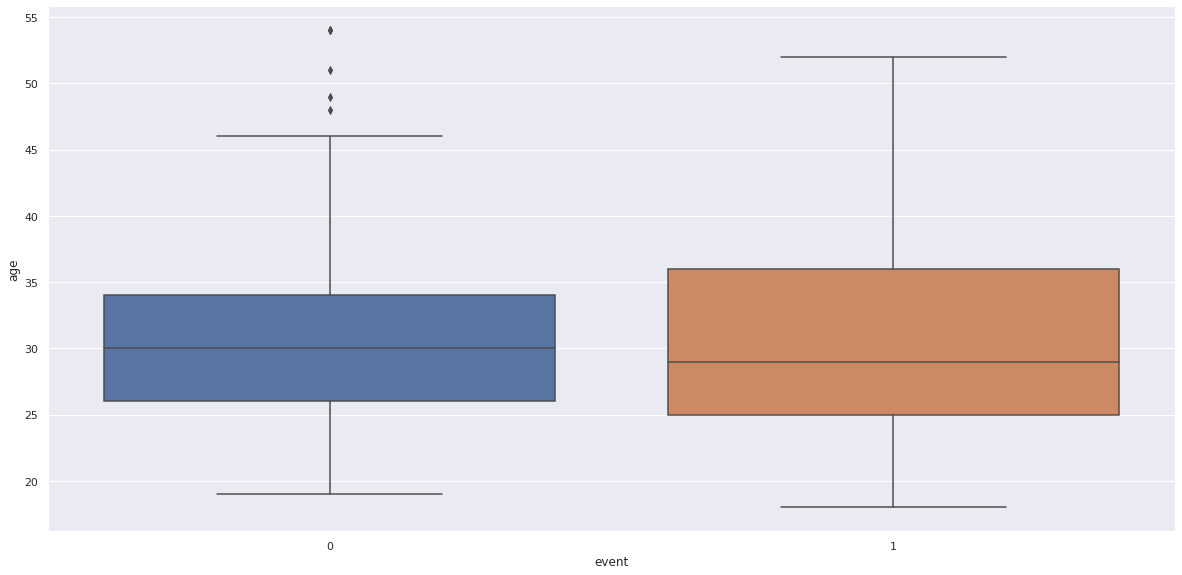

In [28]:
sns.boxplot(x = "event", y = "age", data = X_train);

We can observe there difference between two groups. Most of user who has age around 25 -35 most likely to retain and churn. So we need to focus on this age as a target of the event

**Stag vs Churn**

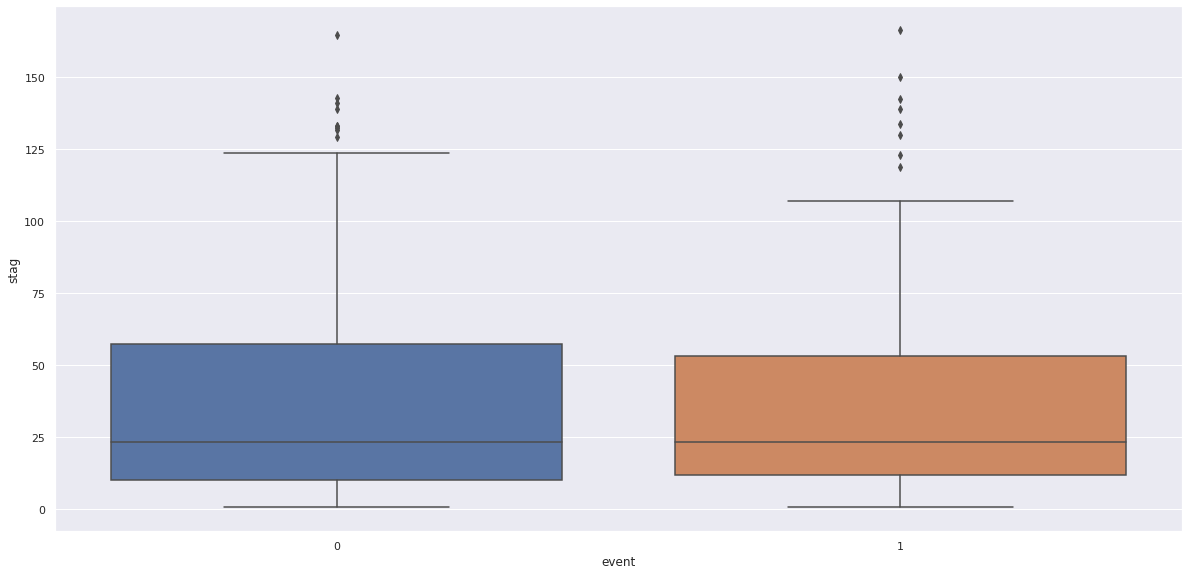

In [29]:
sns.boxplot(x = "event", y = "stag", data = X_train);

From the plot above, we know that people with experience around 12~51 months experience most likely to churn.

**Big5 test scales vs Churn**

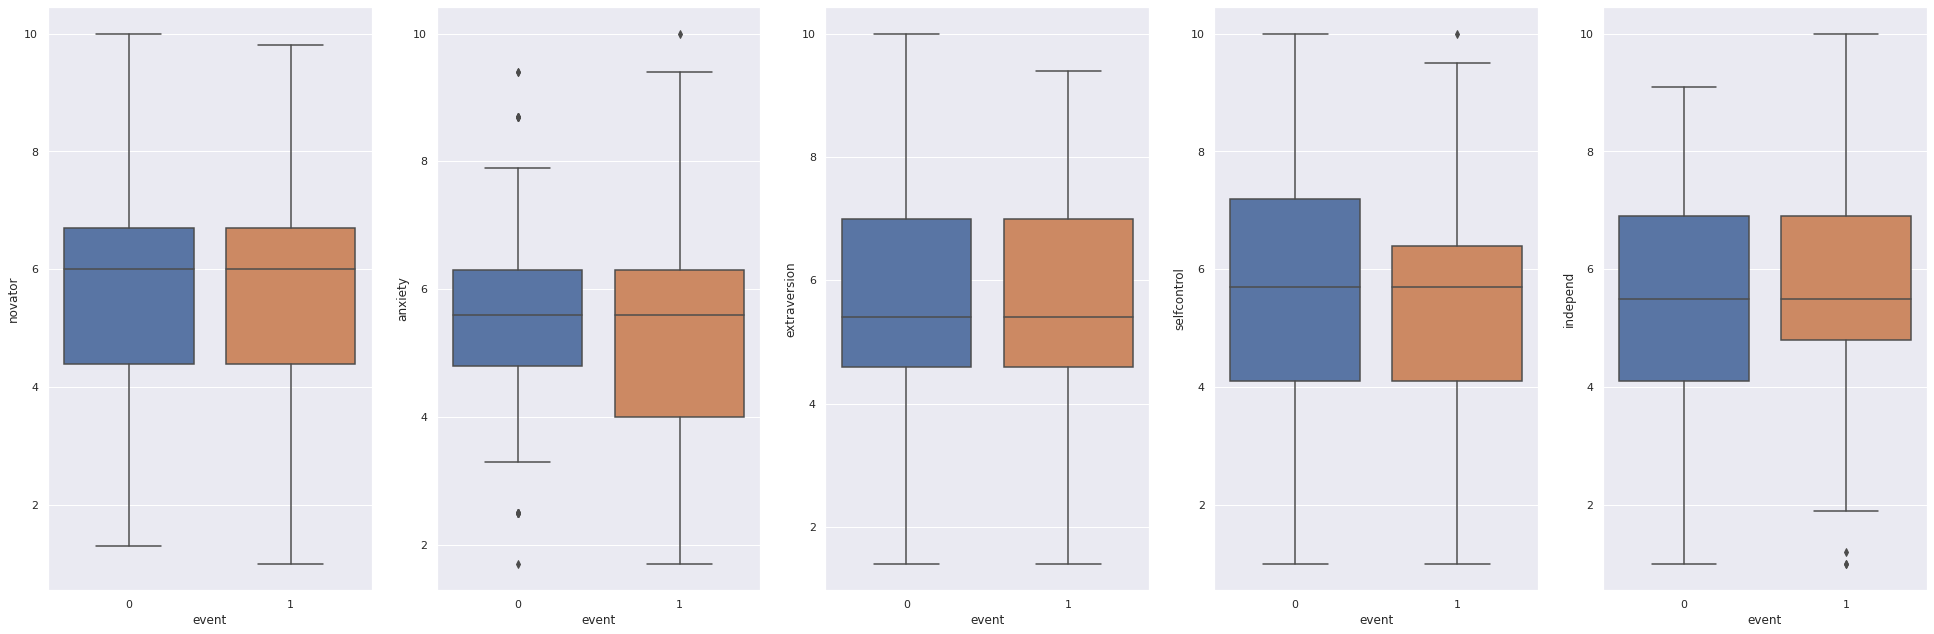

In [30]:
# Check outlier from the train data
fig, axis = plt.subplots(1, 5, figsize=(30, 10))

ax = sns.boxplot(x = "event", y= "novator", data = X_train, ax=axis[0])
ax = sns.boxplot(x = "event", y= "anxiety", data = X_train, ax=axis[1])
ax = sns.boxplot(x = "event", y= "extraversion", data = X_train, ax=axis[2])
ax = sns.boxplot(x = "event", y= "selfcontrol", data = X_train, ax=axis[3])
ax = sns.boxplot(x = "event", y= "independ", data = X_train, ax=axis[4])

As we can see from big5 test plot above, we can make people persona whom most likely to churn :

1. Novator scale around 4.5 ~ 7.5
2. Anxiety scale around 4 ~ 6.5
3. Extraversion scale 5 ~ 7
4. Selfcontrol scale 4 ~ 6.5
5. Independ scale 5 ~ 6.5

However, besides novator and extraversion, all other big 5 scale have different distribution as people whom retained. Also we know that the independ and selfcontrol distribution are mirrorring each other.

## Treatment distribution

In [31]:
X_train

,stag,event,gender,age,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
51,7.589322,1,m,36.000000,no,m,white,foot,4.6,4.8,7.2,6.3,7.5
1053,59.860370,1,f,27.000000,yes,f,white,car,6.2,6.9,4.1,5.6,6.0
149,10.940452,1,m,33.000000,yes,m,white,car,3.0,10.0,5.7,6.3,8.3
370,34.234086,0,f,24.000000,yes,f,white,bus,8.6,6.9,4.9,1.7,4.4
146,13.404517,1,f,30.400333,no,f,white,bus,6.2,4.1,6.4,6.3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,17.577002,1,f,25.000000,no,m,white,bus,6.2,7.6,4.1,4.8,9.0
484,16.065708,0,f,28.000000,yes,f,grey,bus,4.6,5.5,1.8,7.1,6.7
1070,5.815195,1,f,25.000000,no,m,white,bus,4.6,5.5,6.4,5.6,7.5
969,20.960986,1,f,24.000000,yes,m,white,bus,4.6,7.6,7.2,3.3,6.7


In [32]:
# column to encome
categorical_columns = ["gender", "head_gender", "greywage", "way"]

# Encode categorical variables on X train data
dummies = pd.get_dummies(X_train[categorical_columns], drop_first=True)
X_train = pd.concat([X_train.drop(categorical_columns, axis=1), dummies], axis=1)

# Encode categorical variables on X test data
dummies = pd.get_dummies(X_test[categorical_columns], drop_first=True)
X_test = pd.concat([X_test.drop(categorical_columns, axis=1), dummies], axis=1)

In [33]:
is_treat = X_train[X_train.coach == "yes"]
not_treat = X_train[X_train.coach == "no"]

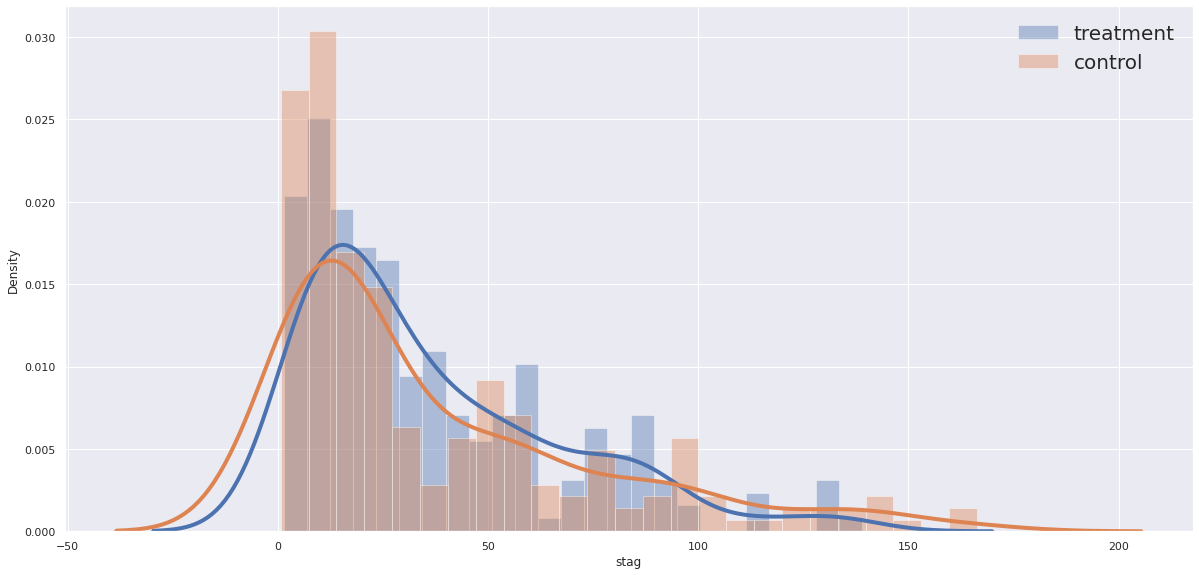

In [34]:
bins = 25
sns.distplot(is_treat.stag, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='treatment')
sns.distplot(not_treat.stag, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

From the plot above, we know that stag has nearly same distribution. We can use this feature.

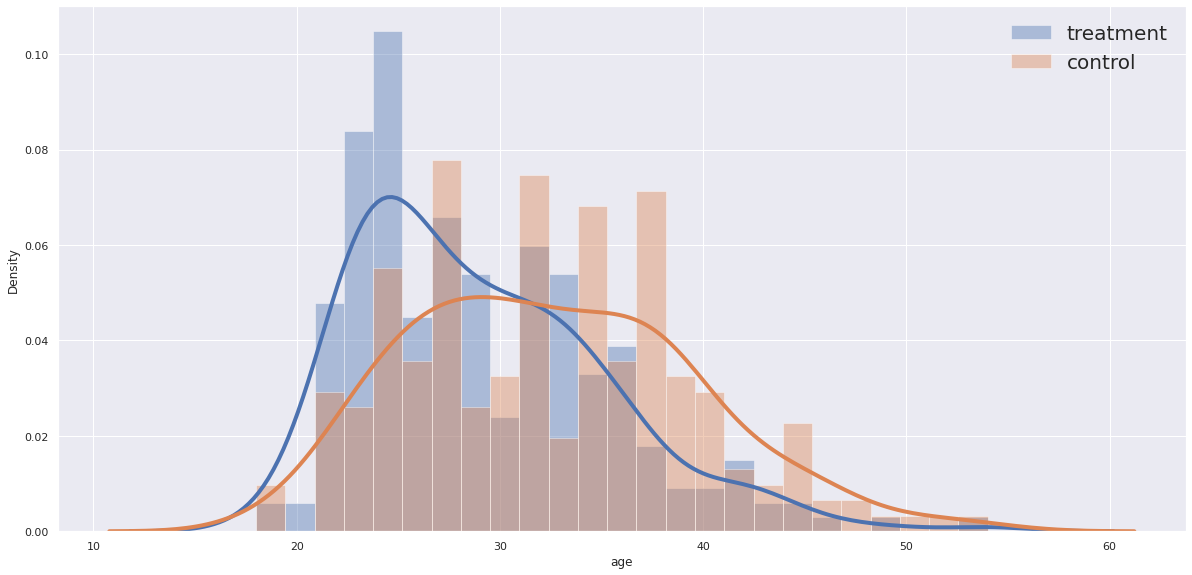

In [35]:
bins = 25
sns.distplot(is_treat.age, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='treatment')
sns.distplot(not_treat.age, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

From the plot above, we know that Age has difference distribution between groups. The we decide to not using this for modelling.

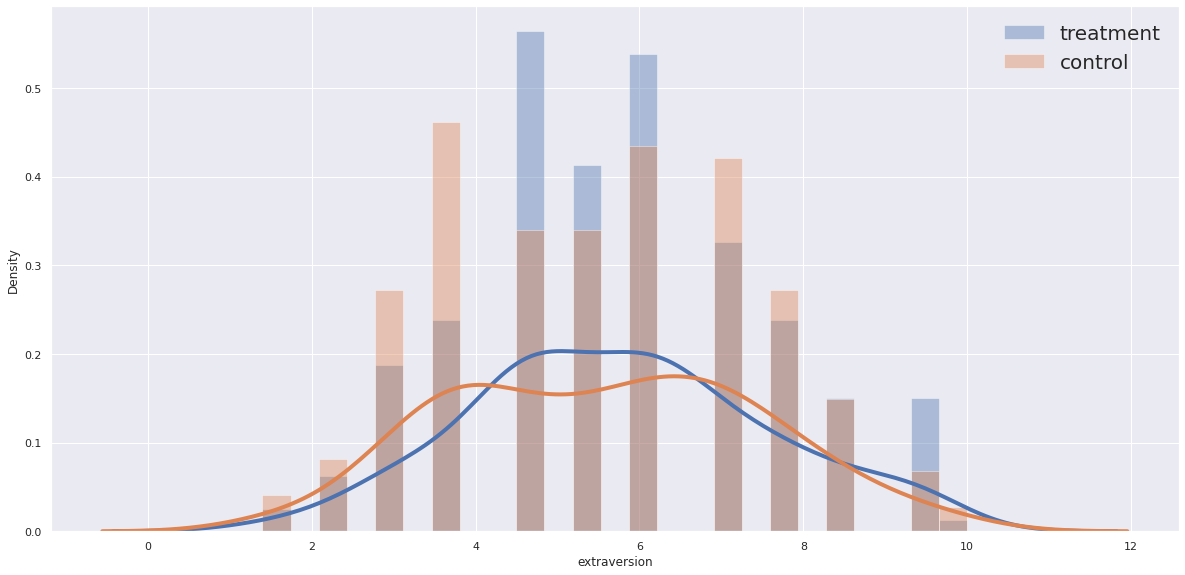

In [36]:
bins = 25
sns.distplot(is_treat.extraversion, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='treatment')
sns.distplot(not_treat.extraversion, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

From the plot above, we know that extraversion has difference distribution between groups. The we decide to not using this for modelling.

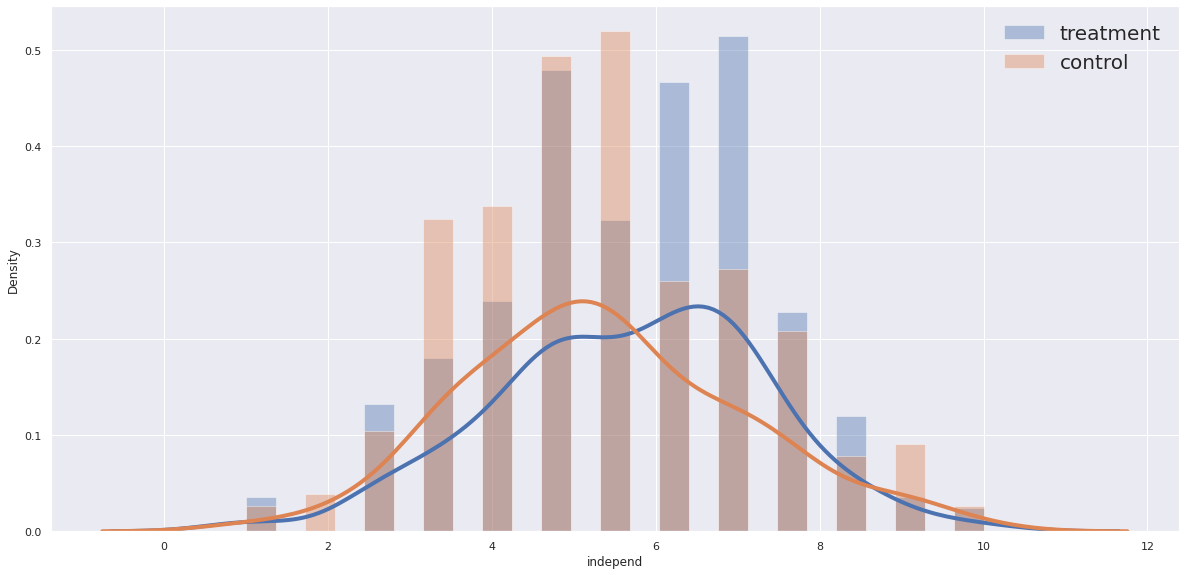

In [37]:
bins = 25
sns.distplot(is_treat.independ, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='treatment')
sns.distplot(not_treat.independ, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

From the plot above, we know that independ has nearly same distribution between groups. We decide to not using this feature.

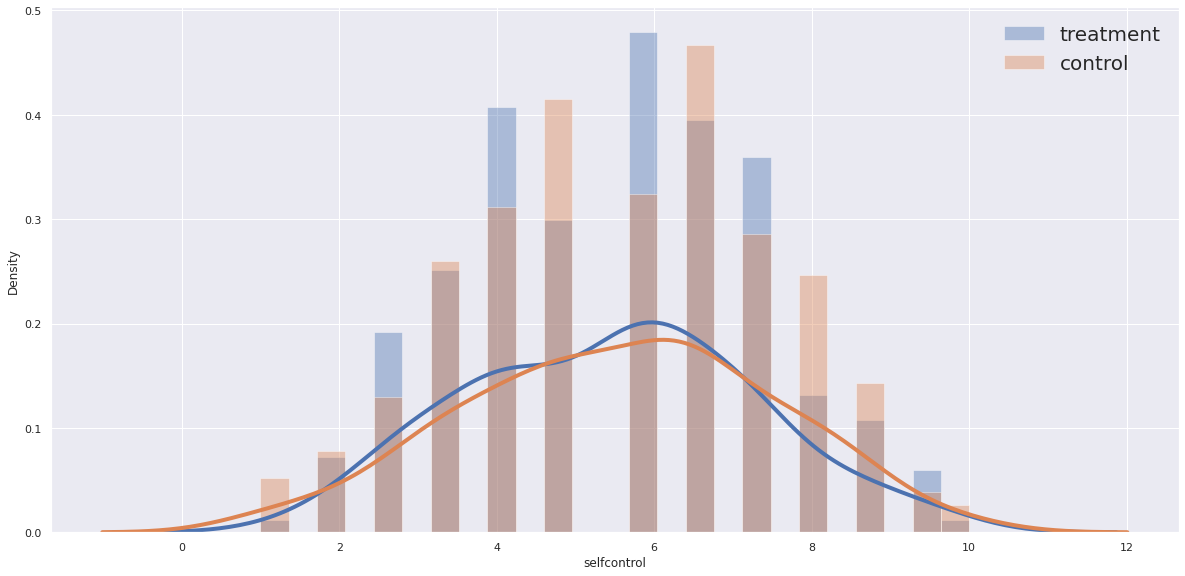

In [38]:
bins = 25
sns.distplot(is_treat.selfcontrol, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='treatment')
sns.distplot(not_treat.selfcontrol, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

From the plot above, we know that selfcontrol has nearly same distribution between groups. We can use this feature.

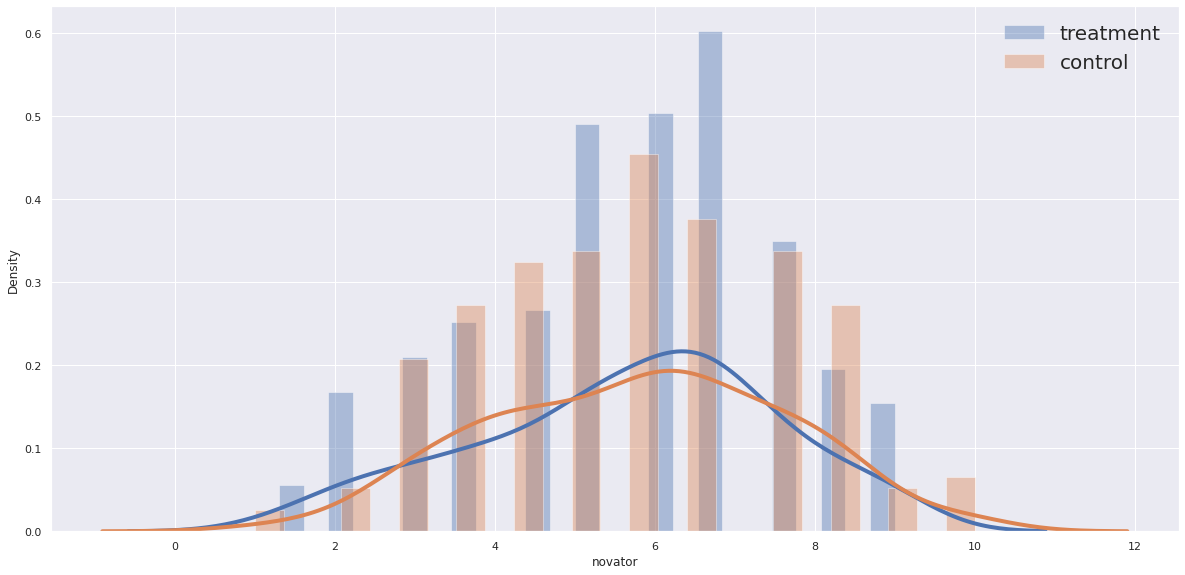

In [39]:
bins = 25
sns.distplot(is_treat.novator, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='treatment')
sns.distplot(not_treat.novator, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

From the plot above, we know that novator has nearly same distribution between groups. We can use this feature.

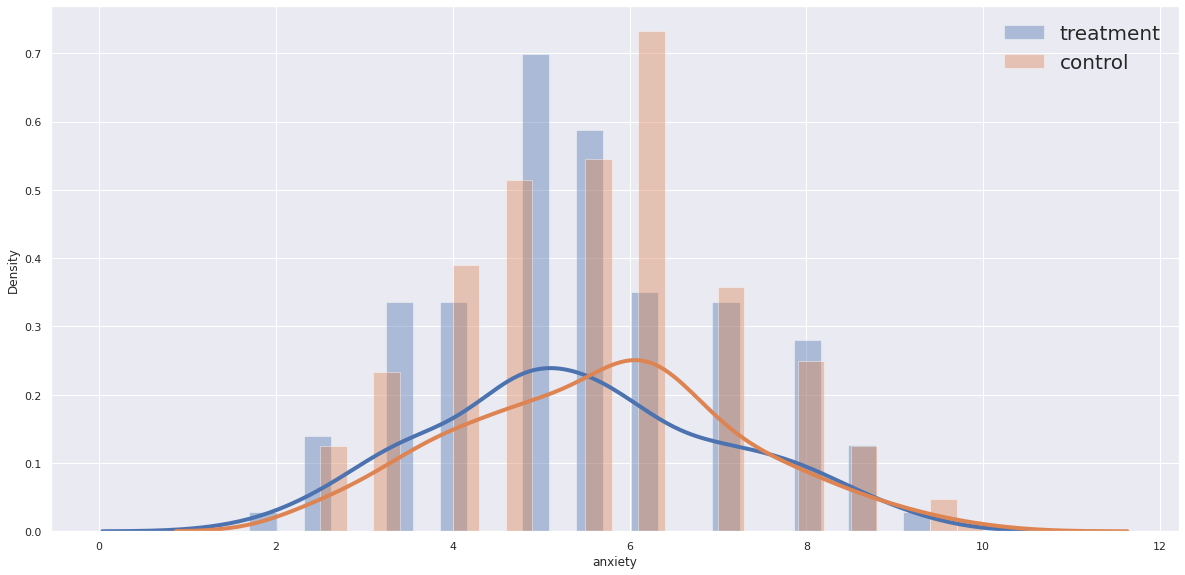

In [40]:
bins = 25
sns.distplot(is_treat.anxiety, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='treatment')
sns.distplot(not_treat.anxiety, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

From the plot above, we know that anxiety has different distribution between groups. We decide to not use this feature.

As summary the feature we can use is stag, selfcontrol, novator. However, novator and selfcontrol have strong correlation each other, we need to remove one of them. Because selfcontrol has strong relation with target, we decide to drop novator.

# Uplift-Tree (Uplift Random Forest)

## Modeling

In [41]:
X_train

,stag,event,age,coach,extraversion,independ,selfcontrol,anxiety,novator,gender_m,head_gender_m,greywage_white,way_car,way_foot
51,7.589322,1,36.000000,no,4.6,4.8,7.2,6.3,7.5,1,1,1,0,1
1053,59.860370,1,27.000000,yes,6.2,6.9,4.1,5.6,6.0,0,0,1,1,0
149,10.940452,1,33.000000,yes,3.0,10.0,5.7,6.3,8.3,1,1,1,1,0
370,34.234086,0,24.000000,yes,8.6,6.9,4.9,1.7,4.4,0,0,1,0,0
146,13.404517,1,30.400333,no,6.2,4.1,6.4,6.3,1.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,17.577002,1,25.000000,no,6.2,7.6,4.1,4.8,9.0,0,1,1,0,0
484,16.065708,0,28.000000,yes,4.6,5.5,1.8,7.1,6.7,0,0,0,0,0
1070,5.815195,1,25.000000,no,4.6,5.5,6.4,5.6,7.5,0,1,1,0,0
969,20.960986,1,24.000000,yes,4.6,7.6,7.2,3.3,6.7,0,1,1,0,0


In [42]:
x_col = X_train.drop(['event', 'coach', 'age', 'extraversion', 'independ', 'anxiety', 'novator'], axis = 1).columns.tolist()
print(x_col)

['stag', 'selfcontrol', 'gender_m', 'head_gender_m', 'greywage_white', 'way_car', 'way_foot']


Define uplift random forest classifier

In [43]:
uplift_model = UpliftRandomForestClassifier(control_name='no', random_state=1000)

Fit model to data

In [44]:
uplift_model.fit(
    X_train[x_col].values,
    treatment = X_train['coach'].values,
    y = X_train['event'].values
)

Do prediction with trained model

In [45]:
y_pred = uplift_model.predict(X_test[x_col].values, full_output=True)

Check the first 5 rows

In [46]:
y_pred.head()

,no,yes,recommended_treatment,delta_yes,max_delta
0,0.627203,0.512211,0,-0.114993,-0.114993
1,0.434458,0.555675,1,0.121217,0.121217
2,0.575255,0.509047,0,-0.066207,-0.066207
3,0.615315,0.468931,0,-0.146384,-0.146384
4,0.549536,0.512348,0,-0.037188,-0.037188


Check uplift distribution

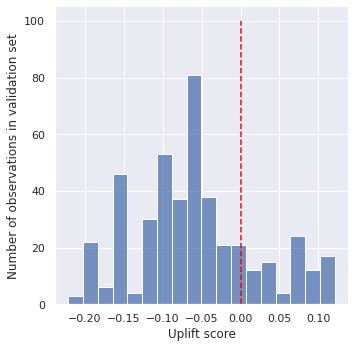

In [47]:
sns.displot(data = y_pred, x = "delta_yes")
plt.vlines([0], 0, 100, linestyles = "dashed", colors = "red")
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set');

In [48]:
# Calculate persuable employee
persuable = y_pred[y_pred['delta_yes']>0]
sleepdogs = y_pred[y_pred['delta_yes']<0]
print("Persuable employee", persuable.shape[0])
print("Sleeping dogs employee", sleepdogs.shape[0])

Persuable employee 91
Sleeping dogs employee 355


**From the summary above, we know that Persuable (treated and not churn) employee are 91 person and Sleeping Dogs (not treated and not churn) employee are 355 person.**

Next, we create prediction with `full_output = False`

In [49]:
y_pred = uplift_model.predict(X_test[x_col].values, full_output=False)

Save our uplift prediction to `result` variable

In [50]:
result = pd.DataFrame(y_pred, columns=[uplift_model.classes_[1]])

In [51]:
result.head()

,yes
0,-0.114993
1,0.121217
2,-0.066207
3,-0.146384
4,-0.037188


Based on uplift response matrix, we need to exclude "Lost Cause" since this group has no interest at all to our campaign

In [52]:
# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
best_treatment = np.where(
    (result < 0).all(axis=1),
    'no',
    result.idxmax(axis=1)
)

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(X_test['coach'] == best_treatment, 1, 0)
actual_is_control = np.where(X_test['coach'] == 'no', 1, 0)

In [53]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)

In [54]:
np.unique(synthetic, return_counts = True)

(array([False,  True]), array([170, 276]))

Exclude user where `synthetic = False`

In [55]:
synth = result[synthetic]

Calculate number of user who churn treated or not treated

In [56]:
auuc_metrics = (synth.assign(
    is_treated = 1 - actual_is_control[synthetic],
    event = X_test.loc[synthetic, 'event'].values,
    uplift_tree = synth.max(axis=1)
).drop(columns=list(['yes'])))

Check the first 5 row

In [57]:
auuc_metrics.head()

,is_treated,event,uplift_tree
0,0,0,-0.114993
1,0,0,0.121217
4,0,0,-0.037188
5,0,1,-0.175491
6,0,0,-0.024880


Calculate treated group based who visit our platform, treated or not

In [58]:
auuc_metrics

,is_treated,event,uplift_tree
0,0,0,-0.114993
1,0,0,0.121217
4,0,0,-0.037188
5,0,1,-0.175491
6,0,0,-0.024880
...,...,...,...
440,0,1,0.044635
441,0,0,-0.066207
442,0,1,-0.150537
444,0,1,-0.160967


# Model Evaluation

## Cumulative Gain Plot

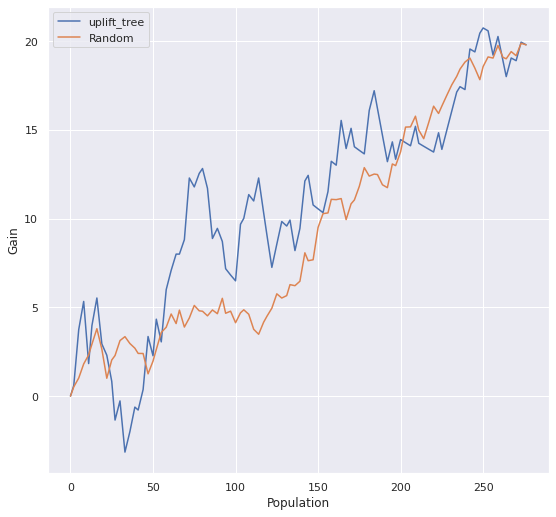

In [59]:
metrics.plot_gain(auuc_metrics, outcome_col='event', treatment_col='is_treated')

From the plot above, the model didn't work properly. This we can see that at some point the model get worse performance than random guess like on population 30-50 and 200-240. Therefore, we need to find more proper variable than we used now.

## AUUC and Qini Score

In [60]:
metrics.auuc_score(auuc_metrics, outcome_col='event', treatment_col='is_treated')

uplift_tree    0.550864
Random         0.461394
dtype: float64

In [61]:
metrics.qini_score(auuc_metrics, outcome_col='event', treatment_col='is_treated')

uplift_tree    0.510105
Random         0.000000
dtype: float64

## Quantile Metrics

If the model is working well, we should see a larger positive difference in the highest decile, decreasing to a small or negative difference in the lowest decile (i.e. treatment rate similar to control rate, or lower than control rate). In other words, as predicted uplift increases, the true uplift from control to treatment group should increase as well.



Create new dataframe object

In [62]:
valid_w_score = X_test.copy()
valid_w_score['Uplift score'] = y_pred

Check the first 5 rows

In [63]:
valid_w_score.head()

,stag,event,age,coach,extraversion,independ,selfcontrol,anxiety,novator,gender_m,head_gender_m,greywage_white,way_car,way_foot,Uplift score
266,18.004107,0,40.0,no,3.0,6.9,4.9,5.6,6.0,0,1,1,0,0,-0.114993
235,16.821355,0,32.0,no,5.4,7.6,8.7,2.5,2.9,0,0,1,0,0,0.121217
174,0.427105,1,24.0,yes,8.6,4.1,4.9,3.3,6.0,0,0,1,0,0,-0.066207
227,2.102669,0,32.0,yes,5.4,5.5,3.3,7.9,8.3,0,1,1,0,1,-0.146384
794,5.092402,0,47.0,no,5.4,7.6,4.9,4.8,6.7,0,0,1,1,0,-0.037188


In [64]:
valid_w_score['coach'].value_counts()

no     232
yes    214
Name: coach, dtype: int64

Bin uplift score by using quantile

In [65]:
score_quantiles, score_quantile_bins = pd.qcut(
    x = valid_w_score['Uplift score'],
    q = 10,
    retbins = True,
    duplicates = 'drop'
)

Calculate number of users for each bin

In [66]:
score_quantiles.value_counts()

(0.00112, 0.075]      52
(-0.0588, -0.0345]    51
(-0.156, -0.117]      48
(-0.117, -0.0988]     46
(-0.0988, -0.086]     46
(-0.223, -0.156]      45
(-0.0665, -0.0588]    45
(-0.0345, 0.00112]    42
(-0.086, -0.0665]     39
(0.075, 0.121]        32
Name: Uplift score, dtype: int64

Save quantile score as new column to `valid_w_score`

In [67]:
valid_w_score['Quantile bin'] = score_quantiles

Check the first 5 rows

In [68]:
valid_w_score[['coach', 'event', 'Uplift score', 'Quantile bin']].head(10)

,coach,event,Uplift score,Quantile bin
266,no,0,-0.114993,"(-0.117, -0.0988]"
235,no,0,0.121217,"(0.075, 0.121]"
174,yes,1,-0.066207,"(-0.0665, -0.0588]"
227,yes,0,-0.146384,"(-0.156, -0.117]"
794,no,0,-0.037188,"(-0.0588, -0.0345]"
1099,no,1,-0.175491,"(-0.223, -0.156]"
1069,no,0,-0.024880,"(-0.0345, 0.00112]"
1109,no,0,-0.150537,"(-0.156, -0.117]"
199,yes,1,0.121217,"(0.075, 0.121]"
35,no,1,-0.069132,"(-0.086, -0.0665]"


Calculate number of samples for each bins

In [69]:
count_by_quantile_and_treatment = valid_w_score.groupby(['Quantile bin', 'coach'])['coach'].count().unstack(-1)

In [70]:
count_by_quantile_and_treatment

coach,no,yes
Quantile bin,,
"(-0.223, -0.156]",23,22
"(-0.156, -0.117]",24,24
"(-0.117, -0.0988]",17,29
"(-0.0988, -0.086]",25,21
"(-0.086, -0.0665]",19,20
"(-0.0665, -0.0588]",31,14
"(-0.0588, -0.0345]",28,23
"(-0.0345, 0.00112]",20,22
"(0.00112, 0.075]",30,22


Visualize the impact of treatment

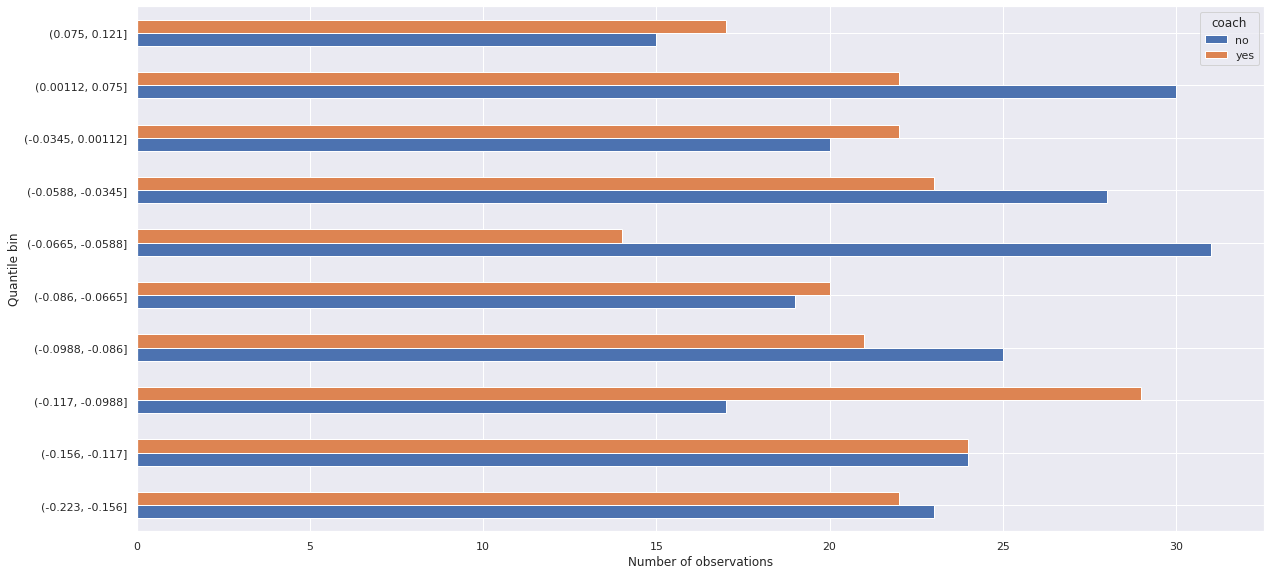

In [71]:
count_by_quantile_and_treatment[['no', 'yes']].plot.barh()
plt.xlabel('Number of observations');

## Uplift Quantile Chart

In [72]:
validation_treatment_mask = valid_w_score['coach'] == "yes"

Get the conversion rates within uplift score quantiles for both groups

In [73]:
treatment_by_quantile = valid_w_score[validation_treatment_mask]\
    .groupby('Quantile bin')['event'].mean()
control_by_quantile = valid_w_score[~validation_treatment_mask]\
    .groupby('Quantile bin')['event'].mean()

In [74]:
true_uplift_by_quantile = treatment_by_quantile - control_by_quantile

Check the first 5 rows

In [75]:
true_uplift_by_quantile.head(5)

Quantile bin
(-0.223, -0.156]    -0.243083
(-0.156, -0.117]     0.041667
(-0.117, -0.0988]    0.032454
(-0.0988, -0.086]   -0.354286
(-0.086, -0.0665]   -0.178947
Name: event, dtype: float64

Visualize uplift quantile chart

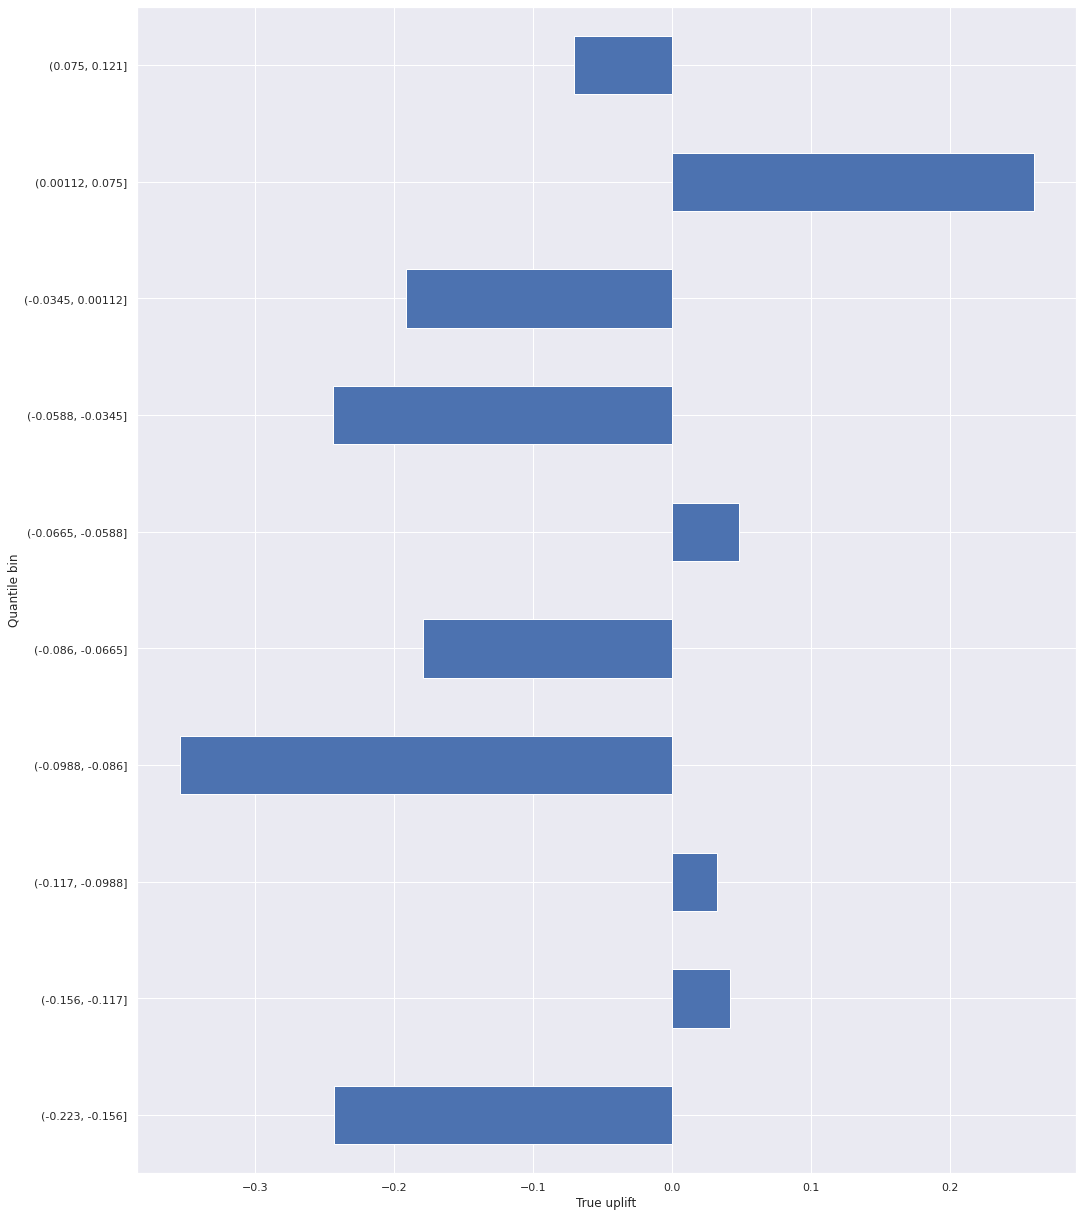

In [76]:
plt.rcParams["figure.figsize"] = (15, 20)
true_uplift_by_quantile.plot.barh()
plt.xlabel('True uplift');

The uplift quantile chart shows that, for the most part, true uplift increases from lower score bins to higher ones, which is what we’d expect to see if the model is working. So it appears our model can effectively segment out customers who more readily respond to treatment.

## Model Interpretation

In [77]:
pd.DataFrame(
    {
        "Variable": x_col,
        "importance": uplift_model.feature_importances_
    }
).sort_values(by="importance", ascending = False)

,Variable,importance
0,stag,0.501894
1,selfcontrol,0.265492
3,head_gender_m,0.204473
5,way_car,0.028142
2,gender_m,0.000000
4,greywage_white,0.000000
6,way_foot,0.000000


From the summary above, we know that the important variable in predicting employee churn is anxiety, stag, selfcontrol, and head gender.

# Conclusion & Recommendation

**Conclusion**

From the analysis above, we can conclude that :

1. By using basic categorical analysis, we can create employee persona that most likely to churn are :
* Female
* Head of employee is Male
* No coach
* White greywage (employee pay for their own tax)
* Going to work on foot
* Experience around 12~51 months.
* Age around 25~35 y.o.
* Big5 scale test Novator scale around 4.5 ~ 7.5, Anxiety scale around 4 ~ 6.5, Extraversion scale 5 ~ 7, Selfcontrol scale 4 ~ 6.5, Independ scale 5 ~ 6.5.

2. The uplift model predicted that Persuable (treated and not churn) employee are 91 person and Sleeping Dogs (not treated and not churn) employee are 355 person.

3. Important variable in predicting employee churn is anxiety, stag, selfcontrol, and head gender.

**Recommendation**

Then, we could create recommendation :
* The company must maintain their employee mental health, as predicted by model (and logic fallacy) anxiety and self control have an important impact on employee churn. The company can create company vacation or team building in order to make working environment more fun.
* From the analysis, the company must bring an ease to their employee. Like paying their tax and provide working vehicles (as we can see on greywage and way values).
* The company also need to give their employee knowledge needs. As we can see the lower stag and not coached employee more likely to churn.
* Last, the company must research more proper data and variable for modelling in order to improve uplifting model.